# Purchase Journey Analysis

This notebook focuses on users who eventually make a purchase, analyzing all their sessions leading up to that purchase event using previously defined categories.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Load the same dataset as in sessions_deepdive.ipynb
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

In [2]:
# Clean the data and filter relevant entries
# Remove entries without user_id or with placeholder user_ids
df_filtered = df[(df['user_id'] != 'none') & (df['user_id'] != 'less-website')].copy()

# Convert timestamp strings to datetime objects
df_filtered['timestamp'] = pd.to_datetime(df_filtered['created_at'], format='ISO8601')

# Define purchase event indicators
purchase_event_types = ['enforce_wait_modal_shown']

# Function to check if an event type indicates a purchase
def is_purchase_event(event_type):
    # Check for exact matches
    if event_type in purchase_event_types:
        return True
    
    # Check for partial matches in case the naming convention varies
    for purchase_type in purchase_event_types:
        if purchase_type.lower() in event_type.lower():
            return True
    
    return False

# Add a column to identify purchase events
df_filtered['is_purchase'] = df_filtered['type'].apply(is_purchase_event)

# Define the other event types we're interested in
df_filtered['is_add_to_cart'] = df_filtered['type'] == 'add-to-cart'
df_filtered['is_checkout'] = df_filtered['type'] == 'checkout'

In [3]:
# Process sessions similar to the original notebook
session_groups = df_filtered.groupby('session_id')

# Extract session start times, end times, duration, and whether each session contains a purchase
session_data = []
for session_id, session_df in session_groups:
    # Skip sessions with invalid or placeholder IDs
    if session_id == 'none' or pd.isna(session_id):
        continue
        
    # Sort session events by timestamp
    session_df = session_df.sort_values('timestamp')
    
    # Get user_id (assuming it's consistent within a session)
    user_id = session_df['user_id'].iloc[0] if not session_df.empty else None
    
    # Get session start and end times
    start_time = session_df['timestamp'].min()
    end_time = session_df['timestamp'].max()
    
    # Calculate session duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    
    # Check for each event type - ensuring uniqueness per session by using .any()
    has_add_to_cart = session_df['is_add_to_cart'].any()
    has_checkout = session_df['is_checkout'].any()
    has_purchase = session_df['is_purchase'].any()
    
    # Find timestamps for FIRST occurrence of each event type
    add_to_cart_time = session_df[session_df['is_add_to_cart']]['timestamp'].min() if has_add_to_cart else None
    checkout_time = session_df[session_df['is_checkout']]['timestamp'].min() if has_checkout else None
    purchase_time = session_df[session_df['is_purchase']]['timestamp'].min() if has_purchase else None
    
    # Determine event sequence order based on first occurrences
    event_order = []
    if has_add_to_cart:
        event_order.append(('add_to_cart', add_to_cart_time))
    if has_checkout:
        event_order.append(('checkout', checkout_time))
    if has_purchase:
        event_order.append(('purchase', purchase_time))
    
    # Sort events by timestamp
    event_order.sort(key=lambda x: x[1])
    
    # Extract the ordered sequence of event types
    event_sequence = [event[0] for event in event_order]
    event_sequence_str = ' → '.join(event_sequence) if event_sequence else 'no_events'
    
    # Collect relevant session details
    session_data.append({
        'session_id': session_id,
        'user_id': user_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration_minutes': duration_minutes,
        'has_add_to_cart': has_add_to_cart,
        'has_checkout': has_checkout,
        'has_purchase': has_purchase,
        'event_sequence': event_sequence_str,
        'event_count': len(session_df)
    })

# Create DataFrame from collected session data
sessions_df = pd.DataFrame(session_data)

# Add flow categorization
def categorize_flow(row):
    # Complete flow
    if row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Complete Flow'
    
    # Add to cart then checkout
    elif row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart then Checkout'
    
    # Checkout then purchase
    elif not row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Checkout then Purchase'
    
    # Just add to cart
    elif row['has_add_to_cart'] and not row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart'
    
    # Just checkout
    elif not row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Checkout'
    
    # Just purchase (unusual but possible)
    elif not row['has_add_to_cart'] and not row['has_checkout'] and row['has_purchase']:
        return 'Direct Purchase'
    
    # Just looking
    else:
        return 'Just Looking'

# Apply the flow categorization
sessions_df['flow_category'] = sessions_df.apply(categorize_flow, axis=1)

# Add the simpler categorization as well
def categorize_session(row):
    if not row['has_purchase']:
        return 'Just Looking'
    elif row['duration_minutes'] >= 20:
        return 'Looking Then Purchasing'
    else:
        return 'Quick Purchase'

sessions_df['category'] = sessions_df.apply(categorize_session, axis=1)

# Show basic statistics
print(f"Total sessions: {len(sessions_df)}")
print(f"Sessions with purchases: {sessions_df['has_purchase'].sum()}")
print(f"Unique users: {sessions_df['user_id'].nunique()}")
users_with_purchases = sessions_df[sessions_df['has_purchase']]['user_id'].nunique()
print(f"Users with at least one purchase: {users_with_purchases}")
print(f"Percentage of users who made purchases: {users_with_purchases / sessions_df['user_id'].nunique() * 100:.2f}%")

Total sessions: 137
Sessions with purchases: 10
Unique users: 36
Users with at least one purchase: 7
Percentage of users who made purchases: 19.44%


## Identifying Users Who Eventually Purchase

Now we'll identify all users who made at least one purchase, and for these users, we'll analyze all their sessions leading up to their first purchase.

In [4]:
# Identify users who made at least one purchase
purchasing_users = sessions_df[sessions_df['has_purchase']]['user_id'].unique()
print(f"Number of users who made at least one purchase: {len(purchasing_users)}")

# For each purchasing user, get all their sessions and sort by time
purchasing_user_sessions = sessions_df[sessions_df['user_id'].isin(purchasing_users)].copy()

# For each user, find their first purchase session
first_purchase_sessions = []
journey_to_purchase_data = []

for user_id in purchasing_users:
    # Get all sessions for this user
    user_sessions = purchasing_user_sessions[purchasing_user_sessions['user_id'] == user_id].sort_values('start_time')
    
    # Find the first purchase session for this user
    first_purchase_idx = user_sessions['has_purchase'].idxmax() if user_sessions['has_purchase'].any() else None
    
    if first_purchase_idx is not None:
        first_purchase_session = user_sessions.loc[first_purchase_idx]
        first_purchase_sessions.append(first_purchase_session)
        
        # Get all sessions before the first purchase
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < first_purchase_session['start_time']]
        
        # Add journey information
        journey_to_purchase_data.append({
            'user_id': user_id,
            'total_sessions_before_purchase': len(pre_purchase_sessions),
            'days_to_first_purchase': (first_purchase_session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24) if len(user_sessions) > 1 else 0,
            'first_purchase_session_id': first_purchase_session['session_id'],
            'first_purchase_category': first_purchase_session['category'],
            'first_purchase_flow': first_purchase_session['flow_category'],
            'pre_purchase_session_categories': pre_purchase_sessions['category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_flow_categories': pre_purchase_sessions['flow_category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_just_looking_count': sum(1 for cat in pre_purchase_sessions['category'] if cat == 'Just Looking'),
            'pre_purchase_add_to_cart_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Add-to-Cart' in flow),
            'pre_purchase_checkout_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Checkout' in flow)
        })

# Create DataFrame for journey analysis
journey_df = pd.DataFrame(journey_to_purchase_data)

# Show some statistics
print(f"Number of users with journey data: {len(journey_df)}")
print(f"Average sessions before first purchase: {journey_df['total_sessions_before_purchase'].mean():.2f}")
print(f"Median sessions before first purchase: {journey_df['total_sessions_before_purchase'].median():.2f}")
print(f"Average days to first purchase: {journey_df['days_to_first_purchase'].mean():.2f}")
print(f"Median days to first purchase: {journey_df['days_to_first_purchase'].median():.2f}")

journey_df.head()

Number of users who made at least one purchase: 7
Number of users with journey data: 7
Average sessions before first purchase: 1.14
Median sessions before first purchase: 1.00
Average days to first purchase: 1.88
Median days to first purchase: 0.03


,user_id,total_sessions_before_purchase,days_to_first_purchase,first_purchase_session_id,first_purchase_category,first_purchase_flow,pre_purchase_session_categories,pre_purchase_flow_categories,pre_purchase_just_looking_count,pre_purchase_add_to_cart_count,pre_purchase_checkout_count
0,e2eb1291-5fec-45e6-bded-3018f0d67d66,2,7.586985,108b415d-714b-4f77-afe5-183d03eb3890,Quick Purchase,Checkout then Purchase,"[Just Looking, Just Looking]","[Just Looking, Just Looking]",2,0,0
1,1850b7a3-5cad-4d7b-a4a0-3c8dd534437d,3,1.489531,67e0f8ad-7487-4ba3-ab21-ef75c541da43,Quick Purchase,Complete Flow,"[Just Looking, Just Looking, Just Looking]","[Just Looking, Just Looking, Just Looking]",3,0,0
2,a8813899-eb7b-49f9-9e97-7f91f995e944,2,4.051127,fe4cf97b-f173-4f40-b9fa-d108c510b764,Quick Purchase,Checkout then Purchase,"[Just Looking, Just Looking]","[Checkout, Just Looking]",2,0,1
3,801d88ba-f931-47c2-a5a1-ef006e2644ad,1,0.029883,85e20096-4a68-4b72-be46-66059b400c4a,Looking Then Purchasing,Complete Flow,[Just Looking],[Just Looking],1,0,0
4,7e54f2ee-060a-467e-b319-9e99d8e58e27,0,0.000000,94851301-6b41-4482-869e-8b93e0082bcc,Looking Then Purchasing,Complete Flow,[],[],0,0,0


## Analyzing First Purchase Sessions

Let's first understand what type of sessions led to the first purchase for each user.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_41487/3624595498.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(flow_order, rotation=45, ha='right')


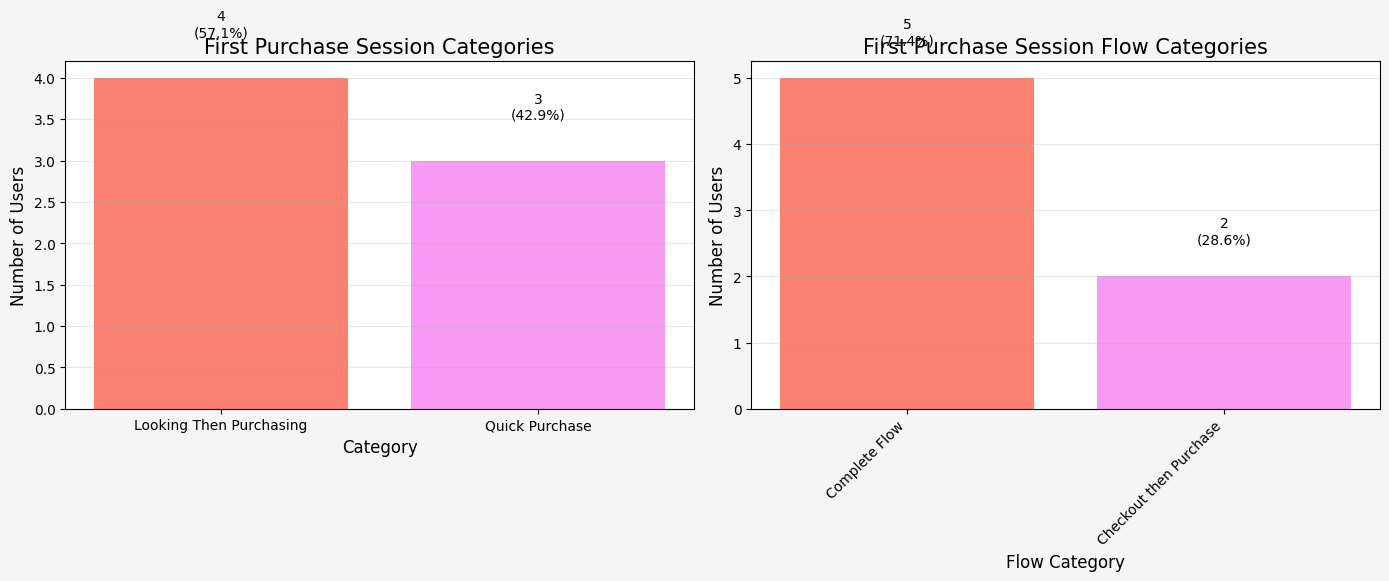

In [5]:
# Distribution of first purchase session categories
first_purchase_categories = journey_df['first_purchase_category'].value_counts()
first_purchase_flows = journey_df['first_purchase_flow'].value_counts()

# Visualize first purchase session categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), facecolor=facecolor)

# Basic categories plot
ax1.bar(first_purchase_categories.index, first_purchase_categories.values, color=colors[:len(first_purchase_categories)])
ax1.set_title('First Purchase Session Categories', fontsize=15)
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Add count and percentage labels
total_users = len(journey_df)
for i, (cat, count) in enumerate(first_purchase_categories.items()):
    percentage = count / total_users * 100
    ax1.text(i, count + 0.5, f"{count}\n({percentage:.1f}%)", ha='center')

# Flow categories plot
flow_order = ['Complete Flow', 'Checkout then Purchase', 'Direct Purchase']
# Only include flow categories that exist in our data
flow_order = [flow for flow in flow_order if flow in first_purchase_flows.index]
flow_counts = [first_purchase_flows.get(flow, 0) for flow in flow_order]

ax2.bar(flow_order, flow_counts, color=colors[:len(flow_order)])
ax2.set_title('First Purchase Session Flow Categories', fontsize=15)
ax2.set_xlabel('Flow Category', fontsize=12)
ax2.set_xticklabels(flow_order, rotation=45, ha='right')
ax2.set_ylabel('Number of Users', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add count and percentage labels
for i, (flow, count) in enumerate(zip(flow_order, flow_counts)):
    percentage = count / total_users * 100
    ax2.text(i, count + 0.5, f"{count}\n({percentage:.1f}%)", ha='center')

plt.tight_layout()
plt.show()

## Sessions Before First Purchase

Let's analyze the number and types of sessions users had before making their first purchase.

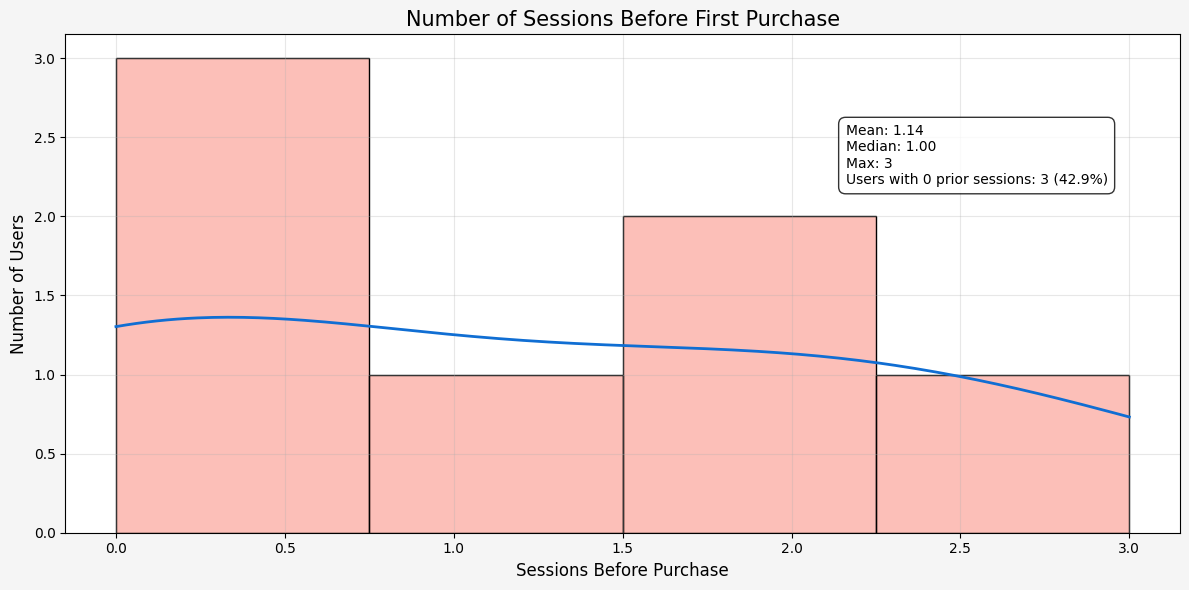

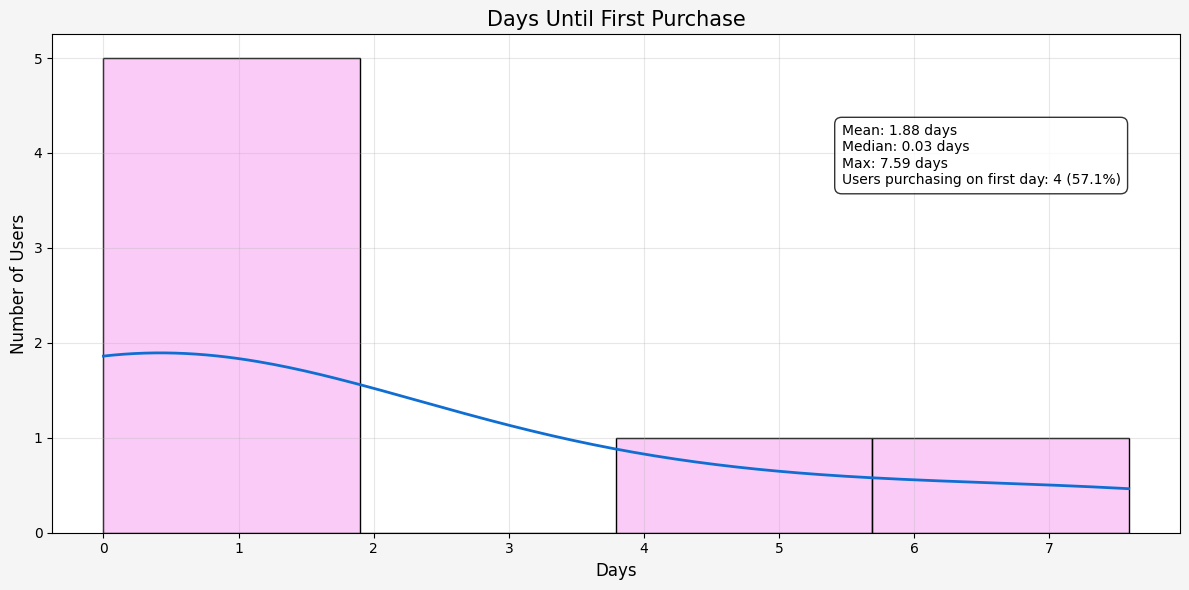

In [6]:
# Create histogram of sessions before first purchase
plt.figure(figsize=(12, 6), facecolor=facecolor)
ax = sns.histplot(journey_df['total_sessions_before_purchase'], kde=True, color=colors[0])
line = ax.lines[0]
line.set_color(colors[5])
line.set_linewidth(2)

plt.title('Number of Sessions Before First Purchase', fontsize=15)
plt.xlabel('Sessions Before Purchase', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
stats_text = f"Mean: {journey_df['total_sessions_before_purchase'].mean():.2f}\n"
stats_text += f"Median: {journey_df['total_sessions_before_purchase'].median():.2f}\n"
stats_text += f"Max: {journey_df['total_sessions_before_purchase'].max()}\n"
stats_text += f"Users with 0 prior sessions: {(journey_df['total_sessions_before_purchase'] == 0).sum()} ({(journey_df['total_sessions_before_purchase'] == 0).sum() / len(journey_df) * 100:.1f}%)"

plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# Create histogram of days to first purchase
plt.figure(figsize=(12, 6), facecolor=facecolor)
ax = sns.histplot(journey_df['days_to_first_purchase'], kde=True, color=colors[1])
line = ax.lines[0]
line.set_color(colors[5])
line.set_linewidth(2)

plt.title('Days Until First Purchase', fontsize=15)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
stats_text = f"Mean: {journey_df['days_to_first_purchase'].mean():.2f} days\n"
stats_text += f"Median: {journey_df['days_to_first_purchase'].median():.2f} days\n"
stats_text += f"Max: {journey_df['days_to_first_purchase'].max():.2f} days\n"
stats_text += f"Users purchasing on first day: {(journey_df['days_to_first_purchase'] < 1).sum()} ({(journey_df['days_to_first_purchase'] < 1).sum() / len(journey_df) * 100:.1f}%)"

plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

## Session Categories Before First Purchase

Let's analyze what types of sessions users had before their first purchase.

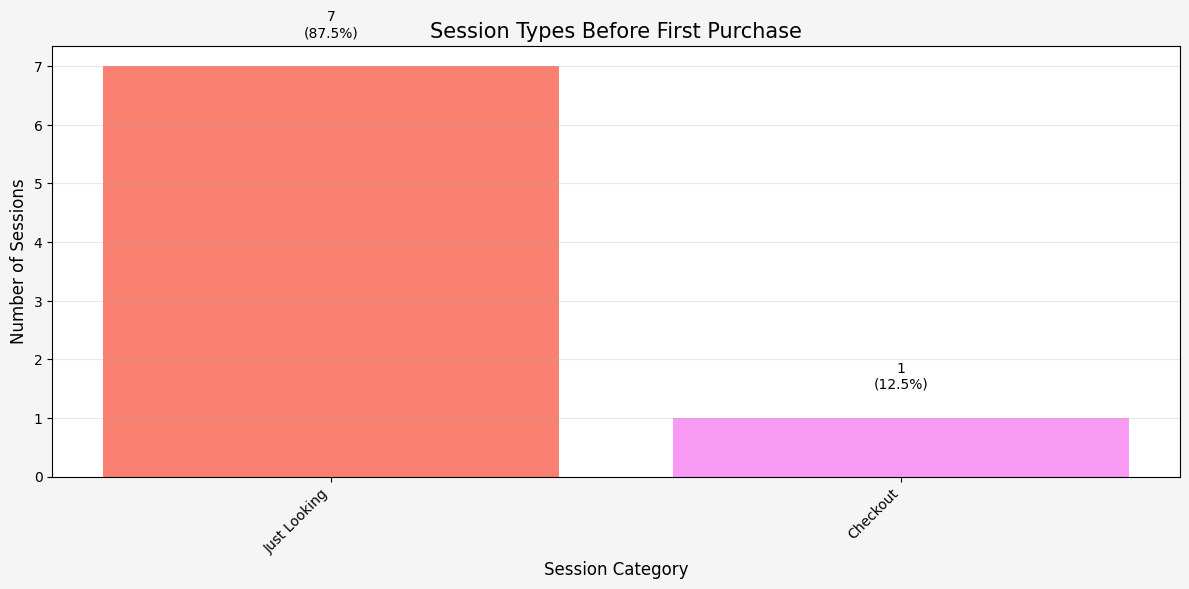

In [7]:
# Analyze the distribution of pre-purchase session types
# First, let's count all pre-purchase sessions by category
pre_purchase_category_counts = {'Just Looking': 0, 'Add-to-Cart': 0, 'Checkout': 0, 'Add-to-Cart then Checkout': 0}
pre_purchase_total = 0

for _, row in journey_df.iterrows():
    for flow in row['pre_purchase_flow_categories']:
        pre_purchase_total += 1
        if flow in pre_purchase_category_counts:
            pre_purchase_category_counts[flow] += 1
        elif flow == 'Just Looking':
            pre_purchase_category_counts['Just Looking'] += 1
        elif 'Add-to-Cart' in flow and 'Checkout' in flow:
            pre_purchase_category_counts['Add-to-Cart then Checkout'] += 1
        elif 'Add-to-Cart' in flow:
            pre_purchase_category_counts['Add-to-Cart'] += 1
        elif 'Checkout' in flow:
            pre_purchase_category_counts['Checkout'] += 1

# Filter out categories with zero counts
pre_purchase_category_counts = {k: v for k, v in pre_purchase_category_counts.items() if v > 0}

# Create bar chart of pre-purchase session categories
plt.figure(figsize=(12, 6), facecolor=facecolor)
categories = list(pre_purchase_category_counts.keys())
counts = list(pre_purchase_category_counts.values())

# Sort by frequency
sorted_indices = np.argsort(counts)[::-1]
sorted_categories = [categories[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

plt.bar(sorted_categories, sorted_counts, color=colors[:len(sorted_categories)])
plt.title('Session Types Before First Purchase', fontsize=15)
plt.xlabel('Session Category', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

# Add count and percentage labels
for i, (cat, count) in enumerate(zip(sorted_categories, sorted_counts)):
    percentage = count / pre_purchase_total * 100 if pre_purchase_total > 0 else 0
    plt.text(i, count + 0.5, f"{count}\n({percentage:.1f}%)", ha='center')

plt.tight_layout()
plt.show()

## Analyzing User Journeys to Purchase

Let's look at the most common patterns of sessions leading up to a purchase.

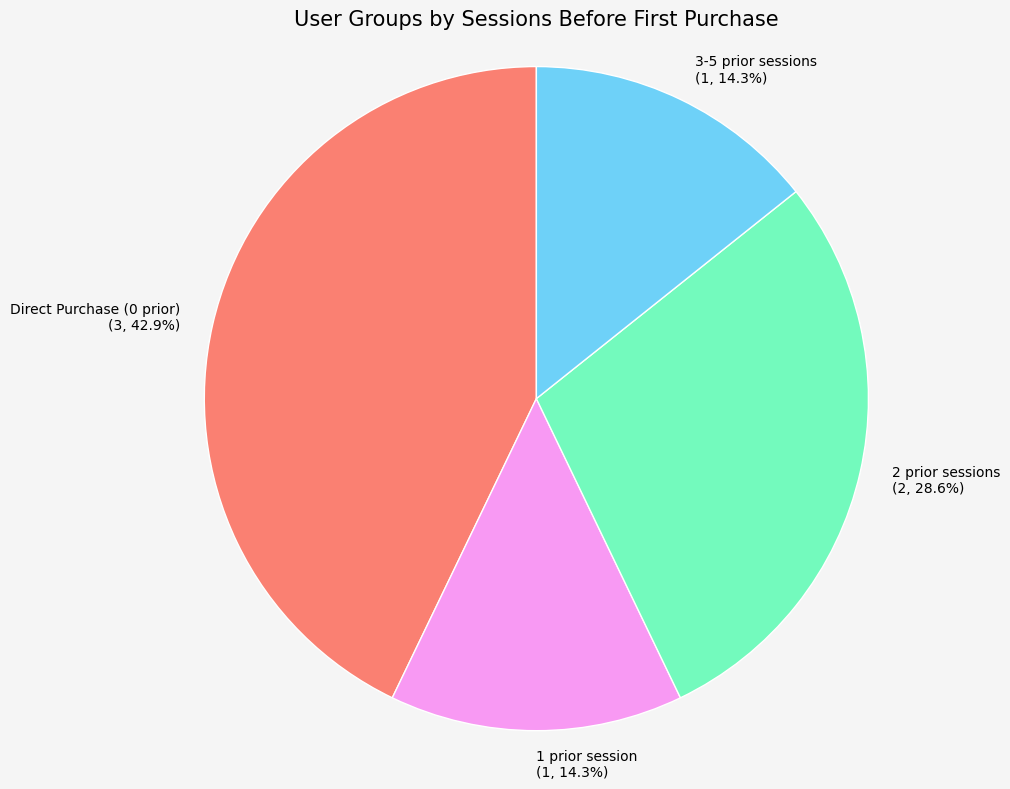

In [8]:
# Group users by number of sessions before purchase for visualization
def get_sessions_group(count):
    if count == 0:
        return 'Direct Purchase (0 prior)'
    elif count == 1:
        return '1 prior session'
    elif count == 2:
        return '2 prior sessions'
    elif count <= 5:
        return '3-5 prior sessions'
    else:
        return '6+ prior sessions'

journey_df['sessions_group'] = journey_df['total_sessions_before_purchase'].apply(get_sessions_group)

# Count users in each group
sessions_group_counts = journey_df['sessions_group'].value_counts().sort_index()
sessions_group_order = ['Direct Purchase (0 prior)', '1 prior session', '2 prior sessions', '3-5 prior sessions', '6+ prior sessions']
# Filter to only include groups that exist in our data
sessions_group_order = [group for group in sessions_group_order if group in sessions_group_counts.index]

# Create pie chart of session groups
plt.figure(figsize=(10, 8), facecolor=facecolor)
plt.pie(
    [sessions_group_counts[group] for group in sessions_group_order],
    labels=[f"{group}\n({sessions_group_counts[group]}, {sessions_group_counts[group]/len(journey_df)*100:.1f}%)" for group in sessions_group_order],
    colors=colors[:len(sessions_group_order)],
    autopct='',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.axis('equal')
plt.title('User Groups by Sessions Before First Purchase', fontsize=15)
plt.tight_layout()
plt.show()

## Journey Timing Analysis

Let's analyze how long it takes for users to make a purchase and if there's a relationship between the number of sessions and time to purchase.

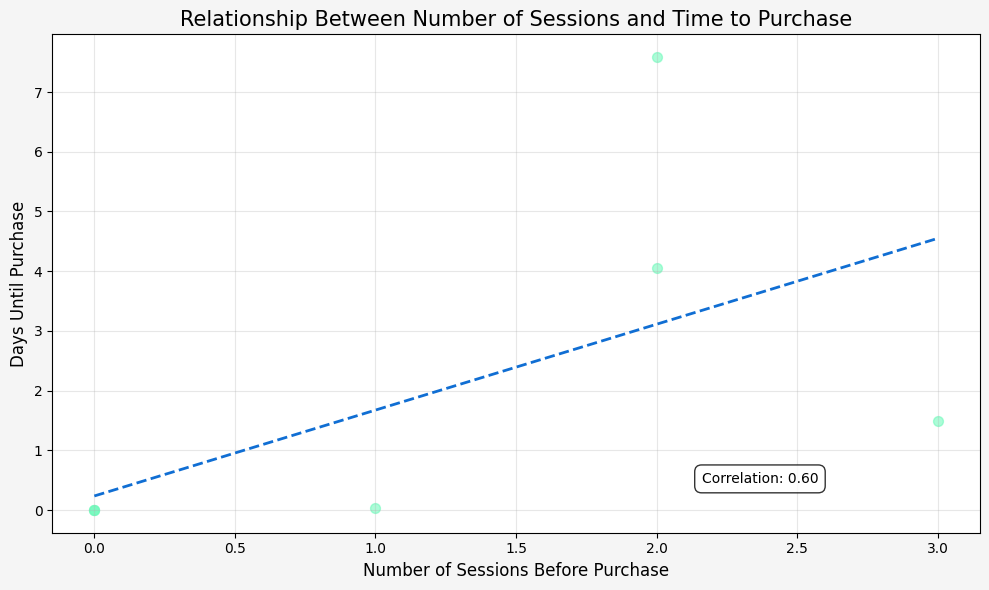

In [9]:
# Scatter plot of days to purchase vs number of sessions
plt.figure(figsize=(10, 6), facecolor=facecolor)
plt.scatter(
    journey_df['total_sessions_before_purchase'], 
    journey_df['days_to_first_purchase'], 
    alpha=0.6, 
    c=colors[2], 
    s=50
)

# Add trend line
z = np.polyfit(journey_df['total_sessions_before_purchase'], journey_df['days_to_first_purchase'], 1)
p = np.poly1d(z)
plt.plot(
    np.sort(journey_df['total_sessions_before_purchase']),
    p(np.sort(journey_df['total_sessions_before_purchase'])),
    "--", color=colors[5], linewidth=2
)

plt.title('Relationship Between Number of Sessions and Time to Purchase', fontsize=15)
plt.xlabel('Number of Sessions Before Purchase', fontsize=12)
plt.ylabel('Days Until Purchase', fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = journey_df['total_sessions_before_purchase'].corr(journey_df['days_to_first_purchase'])
plt.text(0.7, 0.1, f"Correlation: {correlation:.2f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

## Pre-Purchase Activity Analysis

Let's look at how cart additions and checkout attempts influence purchase behavior.

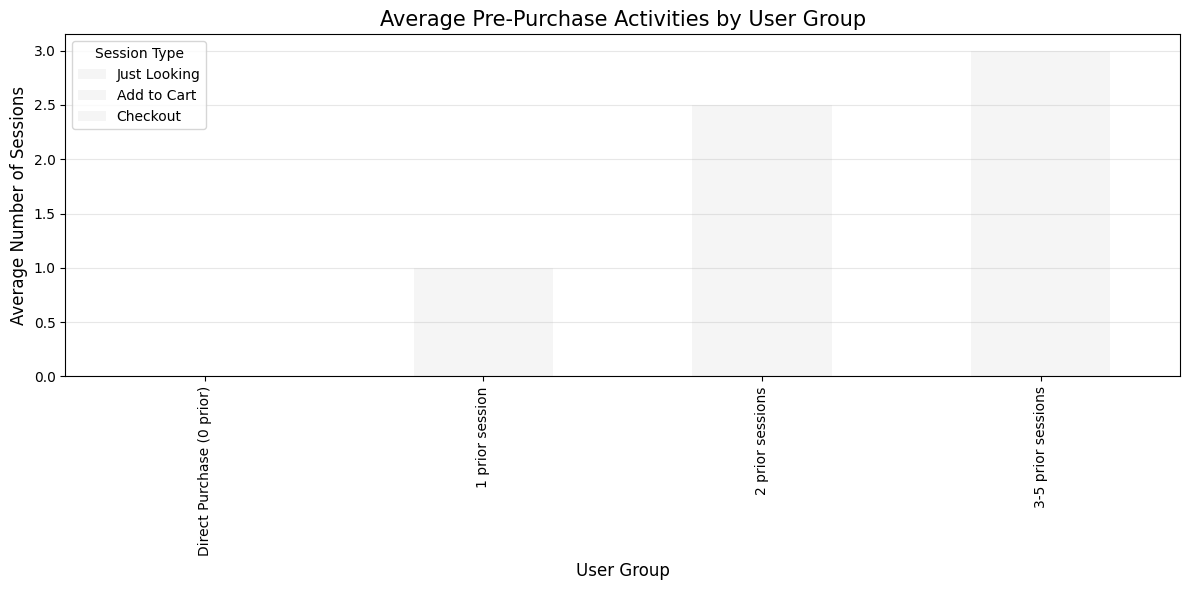

In [10]:
# Create stacked bar chart showing distribution of pre-purchase activities by session group
activity_data = []

for group in sessions_group_order:
    group_df = journey_df[journey_df['sessions_group'] == group]
    
    # For each session group, calculate the average number of each activity type
    if len(group_df) > 0:
        avg_just_looking = group_df['pre_purchase_just_looking_count'].mean()
        avg_add_to_cart = group_df['pre_purchase_add_to_cart_count'].mean()
        avg_checkout = group_df['pre_purchase_checkout_count'].mean()
        
        activity_data.append({
            'session_group': group,
            'Just Looking': avg_just_looking,
            'Add to Cart': avg_add_to_cart,
            'Checkout': avg_checkout
        })

activity_df = pd.DataFrame(activity_data)
activity_df = activity_df.set_index('session_group')

# Create stacked bar chart
activity_df = activity_df.loc[sessions_group_order]  # Ensure the order matches our desired order
activity_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors[:3], facecolor=facecolor)
plt.title('Average Pre-Purchase Activities by User Group', fontsize=15)
plt.xlabel('User Group', fontsize=12)
plt.ylabel('Average Number of Sessions', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.legend(title='Session Type')
plt.tight_layout()
plt.show()

## Progression of Session Types Before Purchase

Let's visualize how session types progress as users get closer to purchase.

Analyzing 1 users with 3+ sessions before purchase


<Figure size 1200x600 with 0 Axes>

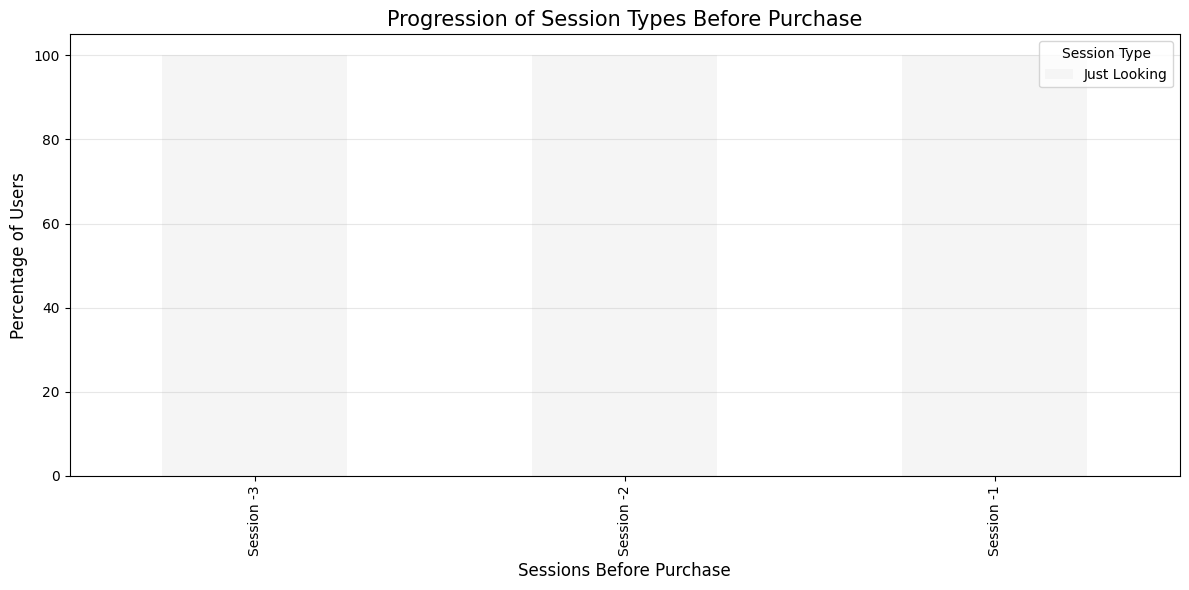


Counts of session types at each position:


session_type,Just Looking
position,
Session -3,1
Session -2,1
Session -1,1


In [11]:
# For users with multiple sessions, analyze the progression of session types
# We'll focus on users with 3 or more sessions before purchase for a more meaningful analysis
multi_session_users = journey_df[journey_df['total_sessions_before_purchase'] >= 3]

if len(multi_session_users) > 0:
    print(f"Analyzing {len(multi_session_users)} users with 3+ sessions before purchase")
    
    # For each position in the sequence (last 3 sessions before purchase), count category types
    sequence_position_data = []
    
    for _, user in multi_session_users.iterrows():
        flow_categories = user['pre_purchase_flow_categories']
        
        # Get the last 3 sessions before purchase
        last_sessions = flow_categories[-3:] if len(flow_categories) >= 3 else flow_categories
        
        # Pad with None if less than 3 sessions
        while len(last_sessions) < 3:
            last_sessions.insert(0, None)
        
        # Record position data
        for i, session_type in enumerate(last_sessions):
            position = f"Session -{3-i}"
            if session_type is not None:
                # Simplify categories for visualization
                if 'Add-to-Cart' in session_type and 'Checkout' in session_type:
                    simplified_type = 'Add-to-Cart then Checkout'
                elif 'Add-to-Cart' in session_type:
                    simplified_type = 'Add-to-Cart'
                elif 'Checkout' in session_type:
                    simplified_type = 'Checkout'
                else:
                    simplified_type = session_type
                
                sequence_position_data.append({
                    'position': position,
                    'session_type': simplified_type
                })
    
    sequence_df = pd.DataFrame(sequence_position_data)
    
    # Create a stacked bar chart showing the distribution of session types at each position
    position_order = ['Session -3', 'Session -2', 'Session -1']
    
    plt.figure(figsize=(12, 6), facecolor=facecolor)
    
    # Count the occurrences of each session type at each position
    position_counts = sequence_df.groupby(['position', 'session_type']).size().unstack(fill_value=0)
    
    # Ensure the position order matches our desired order
    position_counts = position_counts.reindex(position_order)
    
    # Convert to percentages for better visualization
    position_percentages = position_counts.div(position_counts.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart
    position_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors, facecolor=facecolor)
    plt.title('Progression of Session Types Before Purchase', fontsize=15)
    plt.xlabel('Sessions Before Purchase', fontsize=12)
    plt.ylabel('Percentage of Users', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend(title='Session Type')
    plt.tight_layout()
    plt.show()
    
    # Display the raw counts too
    print("\nCounts of session types at each position:")
    display(position_counts)
else:
    print("Not enough users with 3+ sessions for sequence analysis")

## Purchase Journey Summary

Based on our analysis of user journeys leading to purchases, we can draw the following insights:

1. **Session Patterns**: We've identified the typical number of sessions users have before making their first purchase, and how these sessions are distributed over time.

2. **Pre-Purchase Activities**: We've analyzed what types of activities (browsing, adding to cart, checkout attempts) users engage in before finally making a purchase.

3. **Journey Progression**: For users with multiple sessions, we've examined how their behavior evolves as they get closer to making a purchase, showing which activities become more common right before purchase.

4. **Purchase Types**: We've categorized the different types of first purchase sessions (quick purchases vs. deliberate ones) to understand how users ultimately convert.

These insights can be valuable for understanding the user journey, improving conversion optimization, and designing effective intervention strategies for the anti-impulsive purchasing extension.

## Individual User Purchase Journey Visualization

To better understand the specific path users take before making a purchase, let's visualize individual user journeys. This will show us the sequence of session types that lead to a purchase event.

Found 7 users with interesting purchase journeys


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_41487/3455667483.py:113: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


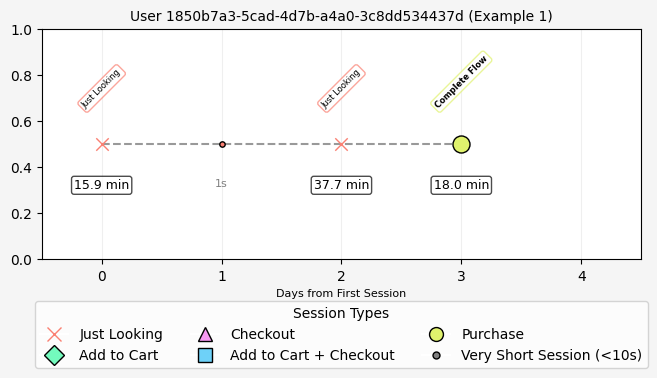

Journey Pattern for User 1850b7a3-5cad-4d7b-a4a0-3c8dd534437d:
Just Looking → [<10s] Just Looking → Just Looking → Complete Flow (Purchase!)

--------------------------------------------------------------------------------



/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_41487/3455667483.py:113: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


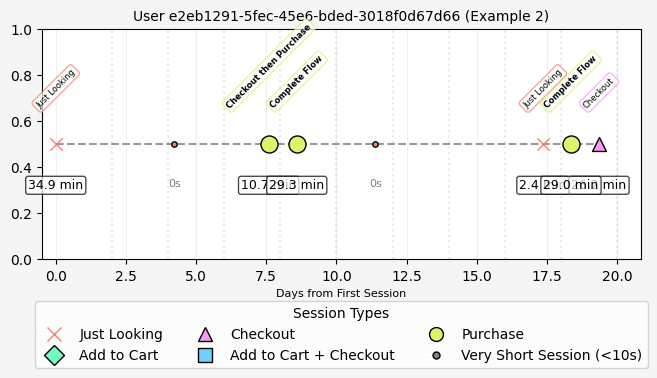

Journey Pattern for User e2eb1291-5fec-45e6-bded-3018f0d67d66:
Just Looking → [<10s] Just Looking → Checkout then Purchase (Purchase!) → Complete Flow (Purchase!) → [<10s] Just Looking → Just Looking → Complete Flow (Purchase!) → Checkout

--------------------------------------------------------------------------------



/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_41487/3455667483.py:113: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


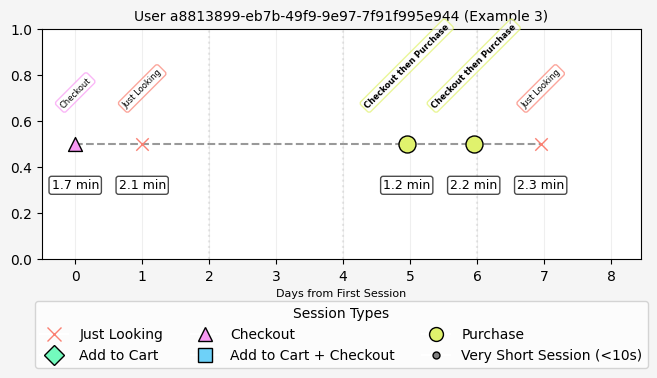

Journey Pattern for User a8813899-eb7b-49f9-9e97-7f91f995e944:
Checkout → Just Looking → Checkout then Purchase (Purchase!) → Checkout then Purchase (Purchase!) → Just Looking

--------------------------------------------------------------------------------



/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_41487/3455667483.py:113: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


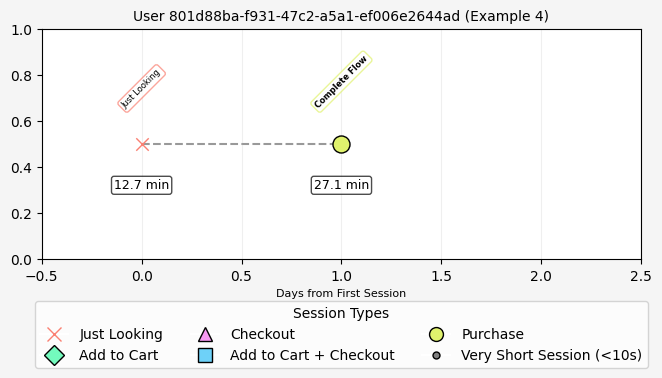

Journey Pattern for User 801d88ba-f931-47c2-a5a1-ef006e2644ad:
Just Looking → Complete Flow (Purchase!)

--------------------------------------------------------------------------------



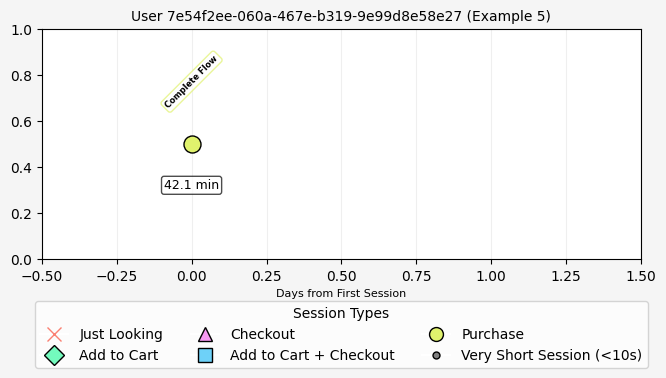

Journey Pattern for User 7e54f2ee-060a-467e-b319-9e99d8e58e27:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



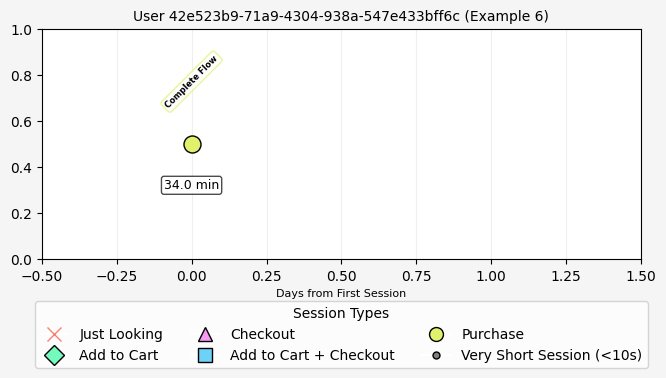

Journey Pattern for User 42e523b9-71a9-4304-938a-547e433bff6c:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



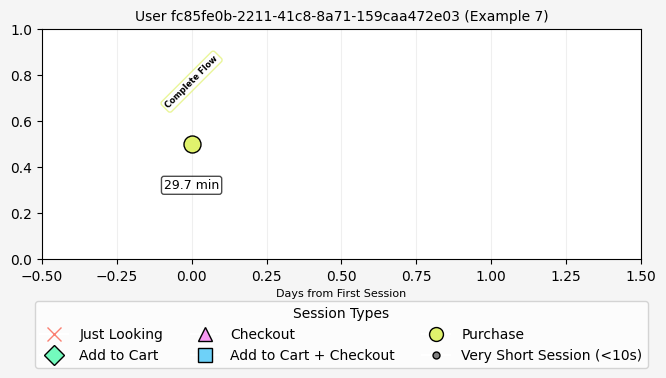

Journey Pattern for User fc85fe0b-2211-41c8-8a71-159caa472e03:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



In [12]:
# Select a few interesting users with multiple sessions before purchase for case studies
# We'll look for users with different patterns to show variety in purchase journeys

# Find users with multiple pre-purchase sessions (3+) for more interesting journeys
journey_examples = journey_df[journey_df['total_sessions_before_purchase'] >= 0].sort_values(
    by=['total_sessions_before_purchase', 'days_to_first_purchase'],
    ascending=[False, False]
).head(15)

if len(journey_examples) > 0:
    print(f"Found {len(journey_examples)} users with interesting purchase journeys")
    
    # Create a figure for each user's journey
    for i, (_, user_journey) in enumerate(journey_examples.iterrows()):
        user_id = user_journey['user_id']
        # Get all sessions for this user
        user_sessions = sessions_df[sessions_df['user_id'] == user_id].sort_values('start_time')
        
        # Find the first purchase session
        purchase_session = sessions_df[(sessions_df['session_id'] == user_journey['first_purchase_session_id'])]
        if purchase_session.empty:
            continue
            
        purchase_time = purchase_session['start_time'].iloc[0]
        
        # Prepare data for visualization
        timeline_data = []
        for _, session in user_sessions.iterrows():
            # No longer skipping very short sessions - we'll just visualize them differently
            
            # Calculate time from first session
            time_from_first = (session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
            
            # Flag for very short sessions (less than 10 seconds)
            is_very_short = session['duration_minutes'] < (10 / 60)
            
            # Determine session type color and marker
            if session['has_purchase']:
                color = colors[4]  # Purchase event
                marker = 'o'
                size = 150
                zorder = 10
            elif 'Add-to-Cart' in session['flow_category'] and 'Checkout' in session['flow_category']:
                color = colors[3]  # Add to cart + checkout
                marker = 's'
                size = 120
                zorder = 8
            elif 'Add-to-Cart' in session['flow_category']:
                color = colors[2]  # Add to cart
                marker = 'D'
                size = 100
                zorder = 6
            elif 'Checkout' in session['flow_category']:
                color = colors[1]  # Checkout
                marker = '^'
                size = 100
                zorder = 7
            else:
                color = colors[0]  # Just looking
                marker = 'x'
                size = 80
                zorder = 5
                
            timeline_data.append({
                'session_id': session['session_id'],
                'time_days': time_from_first,
                'duration_minutes': session['duration_minutes'],
                'flow_category': session['flow_category'],
                'has_purchase': session['has_purchase'],
                'color': color,
                'marker': marker,
                'size': size,
                'zorder': zorder,
                'is_very_short': is_very_short
            })
        
        # Adjust x-coordinates for better spacing when events are too close
        # Sort by time
        timeline_data.sort(key=lambda x: x['time_days'])
        
        # Define minimum gap (in days) that we want between events
        min_gap = 1.0  # Minimum 1 day gap for readability
        
        # Adjust positions
        for j in range(1, len(timeline_data)):
            actual_gap = timeline_data[j]['time_days'] - timeline_data[j-1]['time_days']
            
            # If events are too close together
            if 0 < actual_gap < min_gap:
                # Shift current and all following events to maintain minimum gap
                shift = min_gap - actual_gap
                for k in range(j, len(timeline_data)):
                    timeline_data[k]['time_days'] += shift
        
        # Create the timeline visualization
        plt.figure(figsize=(7, 4), facecolor=facecolor)
        
        # Plot each session as a point
        for session in timeline_data:
            # Use smaller dot for very short sessions
            if session['is_very_short']:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=60,  # Smaller size for very short sessions
                    marker='.',  # Dot marker for very short sessions
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            else:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=session['size'],
                    marker=session['marker'],
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            
            # Add flow category label above point with more vertical space
            # Only add text labels for sessions that aren't very short to avoid clutter
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.65,  # Increased vertical position
                    session['flow_category'],
                    rotation=45,
                    ha='center',
                    va='bottom',
                    fontsize=6,  # Slightly larger font
                    fontweight='bold' if session['has_purchase'] else 'normal',  # Normal weight for purchase events
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor=session['color'], boxstyle='round,pad=0.3'),
                    zorder=session['zorder']
                )
            
            # For purchase sessions, add a separate "Purchase!" label
            # if session['has_purchase']:
            #     plt.text(
            #         session['time_days'],
            #         0.8,  # Higher position to avoid overlap
            #         "Purchase!",
            #         rotation=0,  # No rotation for better visibility
            #         ha='center',
            #         va='bottom',
            #         fontsize=11,  # Slightly larger font for emphasis
            #         fontweight='bold',
            #         color='black',
            #         bbox=dict(facecolor='white', alpha=0.9, edgecolor=colors[4], boxstyle='round,pad=0.3'),
            #         zorder=session['zorder'] + 1  # Higher zorder to stand out
            #     )
            
            # Add duration label below point (only for non-very-short sessions)
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position for better spacing
                    f"{session['duration_minutes']:.1f} min",
                    ha='center',
                    va='top',
                    fontsize=9,
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
                    zorder=session['zorder']
                )
            # For very short sessions, add a small duration label
            else:
                seconds = session['duration_minutes'] * 60
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position
                    f"{seconds:.0f}s",  # Show seconds instead of minutes
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
            
            # Add time from first session as a more subtle label
            # if session['time_days'] > 0.1:  # Skip for first session
            #     plt.text(
            #         session['time_days'],
            #         0.2,  # Lower position
            #         f"Day {session['time_days']:.1f}",
            #         ha='center',
            #         va='top',
            #         fontsize=8,
            #         color='gray',
            #         zorder=session['zorder'] - 1
            #     )
        
        # Connect points with lines - now dotted for better aesthetics
        times = [session['time_days'] for session in timeline_data]
        plt.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1.5)
        
        # Add clear markers for timeline scale
        if max(times) > 3:  # Only add markers if timeline is long enough
            day_markers = list(range(0, int(max(times)) + 2, 2))  # Every 2 days
            for day in day_markers:
                if day > 0:  # Skip day 0
                    plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.5, zorder=0)
        
        # # Add annotations for first session only - purchase annotation is handled by the text label
        # if len(timeline_data) > 0:
        #     plt.annotate('First Session', 
        #                (timeline_data[0]['time_days'], 0.5),
        #                xytext=(timeline_data[0]['time_days'], 0.25),
        #                ha='center', va='top', fontsize=10)
        
        # Set up the plot with improved aesthetics
        plt.title(f'User {user_id} (Example {i+1})', fontsize=10)
        plt.xlabel('Days from First Session', fontsize=8)
        # plt.yticks([])
        plt.grid(True, axis='x', alpha=0.2)
        
        # Add padding to x-axis for better appearance
        plt.xlim(left=-0.5, right=max(times) + 1.5 if times else 1)
        plt.ylim(0, 1)
        
        # Add a legend with improved positioning - now including very short sessions
        legend_elements = [
            plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=10, label='Just Looking', markeredgecolor=colors[0]),
            plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=10, label='Add to Cart', markeredgecolor='black'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=10, label='Checkout', markeredgecolor='black'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label='Add to Cart + Checkout', markeredgecolor='black'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=10, label='Purchase', markeredgecolor='black'),
            plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=10, label='Very Short Session (<10s)', markeredgecolor='black')
        ]
        plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
               title='Session Types', ncol=3, frameon=True, fontsize=10)
        
        # Add journey stats
        # original_days = (purchase_time - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
        # stats_text = f"Total Sessions: {len(timeline_data)}\n"
        # stats_text += f"Actual Days to Purchase: {original_days:.1f}\n"
        # stats_text += f"Sessions before Purchase: {user_journey['total_sessions_before_purchase']}\n"
        # stats_text += f"Just Looking Sessions: {user_journey['pre_purchase_just_looking_count']}\n"
        # stats_text += f"Add to Cart Sessions: {user_journey['pre_purchase_add_to_cart_count']}\n"
        # stats_text += f"Checkout Sessions: {user_journey['pre_purchase_checkout_count']}\n"
        # stats_text += f"Very Short Sessions: {sum(1 for s in timeline_data if s['is_very_short'])}"
        
        # plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
        #          bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
        #          va='top', ha='left', fontsize=10)
        
    
        plt.tight_layout()
        plt.show()
        
        # Display flow pattern as text, with purchase sessions noted
        print(f"Journey Pattern for User {user_id}:")
        journey_pattern = []
        for session in timeline_data:
            prefix = "[<10s] " if session['is_very_short'] else ""
            if session['has_purchase']:
                journey_pattern.append(f"{prefix}{session['flow_category']} (Purchase!)")
            else:
                journey_pattern.append(f"{prefix}{session['flow_category']}")
        print(" → ".join(journey_pattern))
        print("\n" + "-"*80 + "\n")
else:
    print("No users with 3+ sessions found for detailed journey visualization")

In [13]:
# Create a Sankey diagram to visualize the overall flow of users through different session types
# before their first purchase

try:
    import plotly.graph_objects as go
    import networkx as nx
    
    # We'll focus on users with at least one session before purchase
    users_with_pre_sessions = journey_df[journey_df['total_sessions_before_purchase'] > 0]
    
    if len(users_with_pre_sessions) > 0:
        print(f"Creating Sankey diagram for {len(users_with_pre_sessions)} users with pre-purchase sessions")
        
        # Create a graph to track transitions between session types
        G = nx.DiGraph()
        
        # Define the key session types we're interested in tracking
        session_types = ['Start', 'Just Looking', 'Add-to-Cart', 'Checkout', 'Add-to-Cart then Checkout', 'Purchase']
        for session_type in session_types:
            G.add_node(session_type)
        
        # Count transitions between session types
        transitions = {}
        
        # For each user, analyze their journey
        for _, user in users_with_pre_sessions.iterrows():
            # Get their pre-purchase sessions
            pre_sessions = user['pre_purchase_flow_categories']
            
            # Start -> First Session Type
            if pre_sessions:
                first_session = pre_sessions[0]
                key = ('Start', first_session)
                transitions[key] = transitions.get(key, 0) + 1
                
                # Track transitions between session types
                for i in range(len(pre_sessions) - 1):
                    source = pre_sessions[i]
                    target = pre_sessions[i + 1]
                    key = (source, target)
                    transitions[key] = transitions.get(key, 0) + 1
                
                # Last pre-purchase session -> Purchase
                if pre_sessions:
                    last_session = pre_sessions[-1]
                    key = (last_session, 'Purchase')
                    transitions[key] = transitions.get(key, 0) + 1
            else:
                # Direct Start -> Purchase (shouldn't happen in this filtered set)
                key = ('Start', 'Purchase')
                transitions[key] = transitions.get(key, 0) + 1
        
        # Add edges to the graph with weights
        for (source, target), weight in transitions.items():
            G.add_edge(source, target, weight=weight)
        
        # Prepare data for Sankey diagram
        nodes = list(G.nodes())
        node_indices = {node: i for i, node in enumerate(nodes)}
        
        # Create the Sankey diagram data
        links = [
            dict(
                source=node_indices[source],
                target=node_indices[target],
                value=G[source][target]['weight'],
                label=f"{G[source][target]['weight']} users"
            )
            for source, target in G.edges()
        ]
        
        # Define colors for nodes
        node_colors = {
            'Start': colors[0],
            'Just Looking': colors[0],
            'Add-to-Cart': colors[2],
            'Checkout': colors[1],
            'Add-to-Cart then Checkout': colors[3],
            'Purchase': colors[4]
        }
        
        # Create the Sankey diagram
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=20,
                thickness=20,
                line=dict(color='black', width=0.5),
                label=nodes,
                color=[node_colors.get(node, 'gray') for node in nodes]
            ),
            link=dict(
                source=[node_indices[source] for source, target in G.edges()],
                target=[node_indices[target] for source, target in G.edges()],
                value=[G[source][target]['weight'] for source, target in G.edges()],
                label=[f"{G[source][target]['weight']} users" for source, target in G.edges()],
                color='rgba(100,100,100,0.2)'
            )
        )])
        
        fig.update_layout(
            title_text="Aggregate User Journey to First Purchase",
            font=dict(size=12),
            height=600,
            width=1000
        )
        
        fig.show()
    else:
        print("No users with pre-purchase sessions found for Sankey diagram")
        
except ImportError:
    print("Could not create Sankey diagram: plotly or networkx not installed")
    print("Install them with: pip install plotly networkx")

Creating Sankey diagram for 4 users with pre-purchase sessions


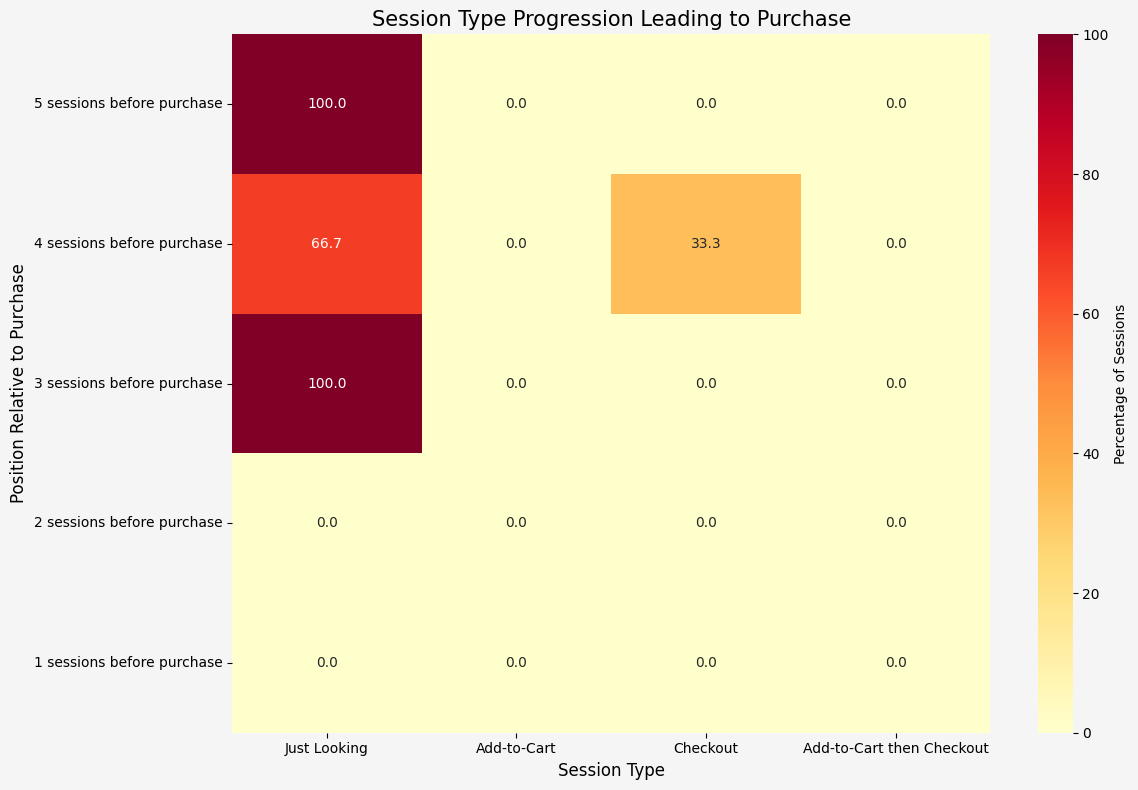

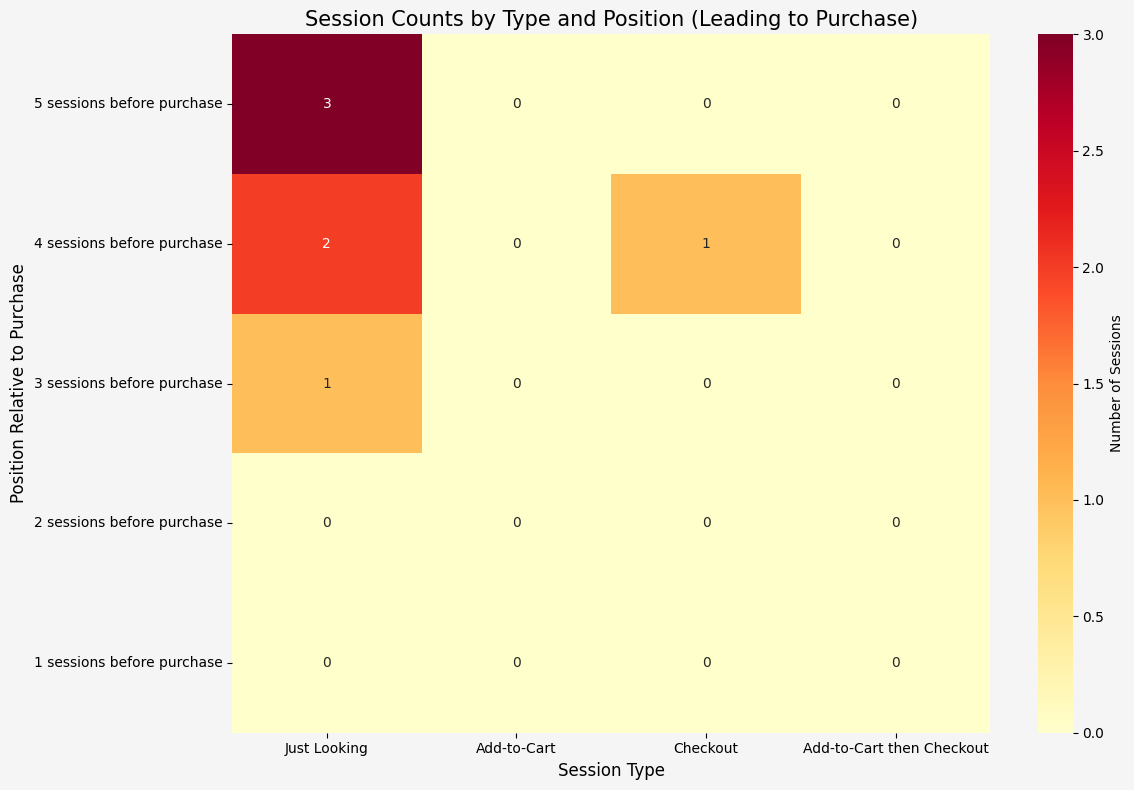

In [14]:
# Create a heatmap showing how session types progress as users move towards purchase
# This will show if certain patterns become more common closer to the purchase event

# Focus on users with at least 2 sessions before purchase for meaningful progression analysis
users_with_progression = journey_df[journey_df['total_sessions_before_purchase'] >= 2]

if len(users_with_progression) > 0:
    # Define the maximum number of sessions we'll track before purchase
    max_sessions_to_track = 5
    
    # Initialize the matrix to store session type counts at each position
    session_types = ['Just Looking', 'Add-to-Cart', 'Checkout', 'Add-to-Cart then Checkout']
    progression_matrix = np.zeros((max_sessions_to_track, len(session_types)))
    
    # Count the occurrences of each session type at each position relative to purchase
    for _, user in users_with_progression.iterrows():
        pre_sessions = user['pre_purchase_flow_categories']
        
        # Focus on last sessions before purchase if there are many
        sessions_to_analyze = pre_sessions[-max_sessions_to_track:] if len(pre_sessions) > max_sessions_to_track else pre_sessions
        
        # Analyze each session starting from the end (closest to purchase)
        for i, session_type in enumerate(reversed(sessions_to_analyze)):
            position = i  # Position 0 is the last session before purchase
            
            if position < max_sessions_to_track:
                # Map the session type to its index
                if session_type == 'Just Looking':
                    type_idx = 0
                elif 'Add-to-Cart' in session_type and 'Checkout' in session_type:
                    type_idx = 3
                elif 'Add-to-Cart' in session_type:
                    type_idx = 1
                elif 'Checkout' in session_type:
                    type_idx = 2
                else:
                    continue  # Skip unrecognized types
                    
                progression_matrix[position, type_idx] += 1
    
    # Normalize by row to get percentages
    row_sums = progression_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    progression_percentages = progression_matrix / row_sums * 100
    
    # Create the heatmap
    plt.figure(figsize=(12, 8), facecolor=facecolor)
    
    # Use a custom colormap that starts from a light color
    cmap = sns.color_palette("YlOrRd", as_cmap=True)
    
    # Plot the heatmap
    ax = sns.heatmap(
        progression_percentages,
        annot=True,
        fmt='.1f',
        cmap=cmap,
        cbar_kws={'label': 'Percentage of Sessions'},
        xticklabels=session_types,
        yticklabels=[f'{max_sessions_to_track-i} sessions before purchase' for i in range(max_sessions_to_track)]
    )
    
    plt.title('Session Type Progression Leading to Purchase', fontsize=15)
    plt.xlabel('Session Type', fontsize=12)
    plt.ylabel('Position Relative to Purchase', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Also show the absolute counts
    plt.figure(figsize=(12, 8), facecolor=facecolor)
    ax = sns.heatmap(
        progression_matrix,
        annot=True,
        fmt='g',  # Display as integer
        cmap=cmap,
        cbar_kws={'label': 'Number of Sessions'},
        xticklabels=session_types,
        yticklabels=[f'{max_sessions_to_track-i} sessions before purchase' for i in range(max_sessions_to_track)]
    )
    
    plt.title('Session Counts by Type and Position (Leading to Purchase)', fontsize=15)
    plt.xlabel('Session Type', fontsize=12)
    plt.ylabel('Position Relative to Purchase', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough users with multiple sessions for progression analysis")

## Individual Journey Analysis Summary

Through the detailed visualization of individual user journeys and aggregate flow patterns, we can observe several key insights:

1. **Purchase Path Diversity**: Users take diverse paths to their first purchase, with some making a purchase after multiple browsing sessions while others proceed more directly.

2. **Session Type Progression**: As users get closer to making a purchase, their session types tend to evolve from simple browsing ("Just Looking") toward more purchase-oriented activities like adding items to cart and proceeding to checkout.

3. **Critical Touchpoints**: The visualizations highlight critical moments in the customer journey where intervention (such as the anti-impulsive purchasing tools) might be most effective.

4. **Time Distribution**: The timeline visualization shows how purchase decisions unfold over time, revealing whether users tend to make purchases quickly after first visit or after extended deliberation across multiple sessions.

These insights provide a more nuanced understanding of the user journey to purchase, which can inform the design of more effective interventions in the anti-impulsive purchasing extension.